In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import spyrit.core.torch as st
from scipy.linalg import hadamard

**First Algorithm: Clients-to-server, aim to compute $B^{*}H^{*}D^{*}X^{*}$ and $B^{*}H^{*}D^{*}Y^{*}$**

In [2]:
def rht(X, Y, signs=None):
    if signs is None:
        signs = np.random.choice([-1, 1], size=X.shape[0])
    D = np.diag(signs)
    result_X = np.dot(D, X)
    result_Y = np.dot(D, Y)

    tensor_matrix_X = torch.tensor(result_X)
    tensor_matrix_Y = torch.tensor(result_Y)

    # Use natural (Kronecker) order: order=False
    tensor_matrix_X = st.fwht(tensor_matrix_X.T, order=False).T
    tensor_matrix_Y = st.fwht(tensor_matrix_Y.T, order=False).T

    X_out = tensor_matrix_X.numpy() / np.sqrt(X.shape[0])
    Y_out = tensor_matrix_Y.numpy() / np.sqrt(Y.shape[0])
    return X_out, Y_out, signs

In [3]:
def algorithm_for_BHDdot(n,k,p,weight,mu_1,mu_2,var_1,var_2,proportion,random_seed=39):
    m = int(n/k)
    ## 2: Generate our GMM raw data, this (i) is not considered as the part of this scheme algorithm.
    mu_1_vector = np.ones(p) * mu_1
    sigma_1_vector = np.eye(p) * var_1
    mu_2_vector = np.ones(p) * mu_2
    sigma_2_vector = np.eye(p) * var_2
    weight_1 = weight
    data_proportion_1_no_rows = int(n * weight_1)
    data_proportion_2_no_rows = n - data_proportion_1_no_rows
    np.random.seed(random_seed)
    data_1 = np.random.multivariate_normal(mu_1_vector, sigma_1_vector,size=data_proportion_1_no_rows)
    data_2 = np.random.multivariate_normal(mu_2_vector, sigma_2_vector,size=data_proportion_2_no_rows)
    X_raw = np.vstack((data_1, data_2))
    np.random.shuffle(X_raw)
    epsilon = np.random.normal(0,1,size = n)
    beta = np.random.normal(0,1,size = p)
    Y_raw = np.dot(X_raw,beta) + epsilon
    ## 3a: Partition the data equally to k clients.
    X_clients = np.array_split(X_raw, k)
    Y_clients = np.array_split(Y_raw, k)
    ## 3b: draw global Rademacher signs once
    np.random.seed(random_seed)
    global_signs = np.random.choice([-1, 1], size=n)
    ## 4: Apply normalized rht on each client side
    X_rht_clients = []
    Y_rht_clients = []
    for i in range(k):
      start = i * m
      end   = (i+1) * m
      signs_i = global_signs[start:end]
      X_rht, Y_rht, _ = rht(X_clients[i], Y_clients[i].reshape(-1, 1), signs=signs_i)
      X_rht_clients.append(X_rht)
      Y_rht_clients.append(Y_rht)
    ## 5a: Generate a randomized np.index list, the length is 'proportion' * m for each client (but fixed for all of them_meaning the same indices are used for all clients), index range is from 0 to m-1 (inclusive).
    np.random.seed(random_seed)
    selected_indices = np.random.choice(m, size=int(proportion * m), replace=False)
    ## 5b: make this index list to a diagonal matrix, with 1 on the selected indices and 0 elsewhere, so the dimension should be m x m.
    S_matrix = np.zeros((m, m))
    for index in selected_indices:
        S_matrix[index, index] = 1
    ## 6: Use this index matrix S to do on each client: S*H_m*D_i*X_i and S*H_m*D_i*Y_i (this process could be done either by using 5a or 5b, choose one which is faster).
    X_final_clients = []
    Y_final_clients = []
    for i in range(k):
        X_final = np.dot(S_matrix, X_rht_clients[i])
        Y_final = np.dot(S_matrix, Y_rht_clients[i])
        X_final_clients.append(X_final)
        Y_final_clients.append(Y_final)
    ## 7a: concatenate all the clients' final X and Y by columns to recover the dimension of (proportion*n) x p for X and (proportion*n) x 1 for Y.
    X_final_all = np.vstack(X_final_clients)
    Y_final_all = np.vstack(Y_final_clients)
    ## 7b: Compute the kronecker product: H_k ⊗ I_m first (H_k is the normalized hadamard matrix with dimension k xk, I_m is the identity matrix with dimension m x m), then multiply it with the concatenated X and Y from 7a.
    H_k = hadamard(k) / np.sqrt(k)
    I_m = np.eye(m)
    H_k_kron_I_m = np.kron(H_k, I_m)
    X_global = np.dot(H_k_kron_I_m, X_final_all)
    Y_global = np.dot(H_k_kron_I_m, Y_final_all)
    # 8: Global RHT using the *same* signs in block order
    X_rht_global, Y_rht_global, _ = rht(X_raw, Y_raw.reshape(-1, 1), signs=global_signs)
    ## I_k is the identity matrix with dimension k x k
    I_k = np.eye(k)
    ## B_matrix is the kronecker product of I_k and S_matrix
    B_matrix = np.kron(I_k, S_matrix)
    X_global_compare_1 = np.dot(B_matrix, X_rht_global)
    Y_global_compare_1 = np.dot(B_matrix, Y_rht_global)
    return X_global, Y_global, X_global_compare_1, Y_global_compare_1
## Example usage:
n = 8192  # number of samples
k = 16   # number of clients
p = 100   # number of features
proportion = 0.2  # proportion of data to be selected
X_transformed, Y_transformed, X_transformed_1, Y_transformed_1 = algorithm_for_BHDdot(n, k, p, weight=0.8, mu_1=0, mu_2=5, var_1=1, var_2=10, proportion=proportion, random_seed=39)

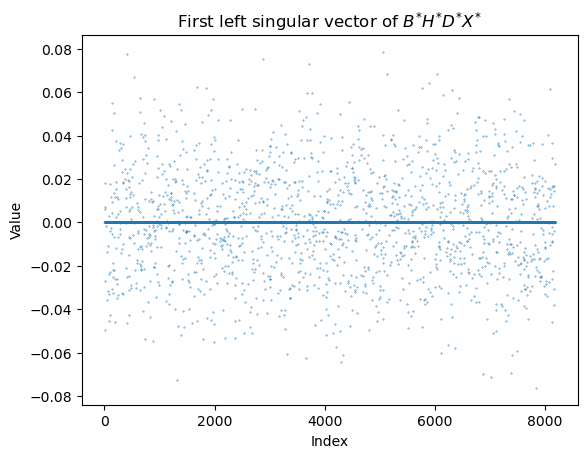

In [4]:
## Demonstrate the first left singular vector of X_transformed by plotting it as dots: manifesting the normalization effects of rht
U_1,s_1,Vh_1 = np.linalg.svd(X_transformed)
U_1_vector_1 = U_1[:,0]
plt.scatter(range(len(U_1_vector_1)),U_1_vector_1,s=0.1)
plt.title('First left singular vector of $B^{*}H^{*}D^{*}X^{*}$')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [5]:
max_diff_X = np.max(np.abs(X_transformed - X_transformed_1))
max_diff_Y = np.max(np.abs(Y_transformed - Y_transformed_1))
print("max |ΔX| =", max_diff_X)
print("max |ΔY| =", max_diff_Y)

max |ΔX| = 5.329070518200751e-15
max |ΔY| = 2.842170943040401e-14


**So the conclusion is X_transformed and X_transformed_1 is exactly the same.**

*We garantee that this algorithm could achieve exactly the same between X_transformed (theoretical global result) and X_transformed_1 (Our algorithm local computation here)*